# PRACTICA SIM - SEGMENTACION EEG
"""
Created on Fri Apr 16 09:39:45 2021

@author: pbonomini

ELECTROENCEFALOGRAMA (EEG)

"""

Monto el drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importo librerías que voy a utilizar:

In [2]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import scipy.io 

## Visualización de canales de EEG


Cargo archivo `eeg_ritmos.mat`:

In [3]:
data = scipy.io.loadmat('/content/drive/MyDrive/SIM2022Q2/señales/EEGritmos.mat')
print(sorted(data.keys()))

['__globals__', '__header__', '__version__', 'eeg', 'fs']


Veo que hay dentro de `'data'` del archivo cargado:

In [4]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jun 01 12:13:10 2021',
 '__version__': '1.0',
 '__globals__': [],
 'eeg': array([[ 0.86570241,  1.14607309, -0.96790164, ...,  0.49246472,
          0.62009521,  0.43227814]]),
 'fs': array([[256]], dtype=uint16)}

Leemos y mostramos señal

In [5]:
eeg_signal = data['eeg'].flatten()
N = eeg_signal.shape[0]
print("N: {}".format(N))
fs = data['fs'][0][0]
Ts = 1/fs

N: 10240


## Ritmos del EEG


Armo un diccionario con los ritmos cerebrales:

In [6]:
def get_rythm(freq):
  rythms = {
      "beta" : {"desc": "Ritmo Beta", "freq": [13.0, 30.0], "color": "r"},
      "alpha": {"desc": "Ritmo Alfa", "freq": [ 8.0, 13.0], "color": "k"},
      "theta": {"desc": "Ritmo Teta", "freq": [ 4.0,  8.0], "color": "g"},
      "delta": {"desc": "Ritmo Delta", "freq": [ 0.5,  4.0], "color": "o"},
      "gamma": {"desc": "Ritmo Gama", "freq": [30.0, 64.0], "color": "y"}
  } 

  for rythm_type in rythms:
    # print(rythms[rythm_type])
    if rythms[rythm_type]["freq"][0] <= freq <= rythms[rythm_type]["freq"][1]:
      return rythms[rythm_type]

  return {"desc": "Ritmo Desconocido", "freq": [None, None], "color": "b"}

In [7]:
get_rythm(10.0)

{'desc': 'Ritmo Alfa', 'freq': [8.0, 13.0], 'color': 'k'}

## Densidad espectral de energía

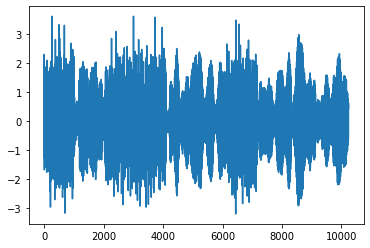

In [8]:
eeg_time = np.arange(0,N)
plt.plot(eeg_time,eeg_signal)

In [9]:
def periodogram(signal):
  FFT = np.fft.fft(signal)
  S = (np.abs(FFT)**2)/len(signal)
  return S

(0.0, 128.0)

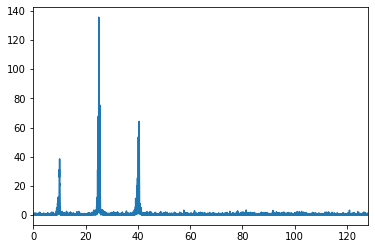

In [10]:
# Hacemos periodograma
S_EEG = periodogram(eeg_signal)
freq = np.linspace(0,2*np.pi,len(eeg_signal))
plt.plot(freq*fs/(2*np.pi),S_EEG)
plt.xlim(0,fs/2)


## Consigna 1: Segmentación por Periodograma

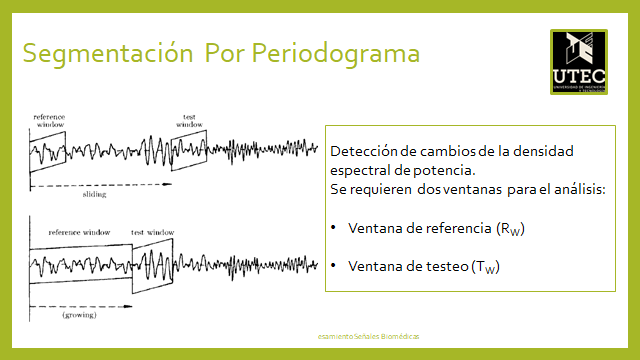

### Periodograma

Intervienen el periodograma desplazado ($r_x(k,n)$) y el de la ventana de referencia ($r_x(k,0)$)



> $n$: posicion variable de la ventana

> $k$: parámetro que indica el desplazamiento para calcular la correlación de la ventana en $n$

La disimilitud en este caso es el error medio cuadrático entre ambos espectros de las ventanas, pero normalizado por la potencia de ambas ventanas.

Para mejorar el costo computacional se utiliza una formula equivalente basada en la autocorrelación móvil como parámtro para calcular $\Delta$

En el denominador tenemos a la autocorrelación en $k = 0$ porque corresponde a la potencia de la ventana justamente.

Una vez calculado la disimilitud en todo $n$, se determina un umbral ($\eta$)para determinar la finalización de un segmento. Es decir, si $\Delta > \eta$ esa ventana pertenece a otro segmento.

---



Se requieren dos ventanas para el análisis
* Ventana de referencia ($r_X(k,0)$)
* Ventana de testeo ($r_X(k,n)$) 

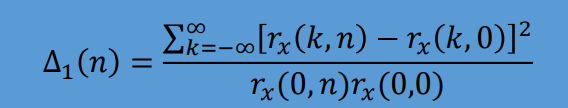

In [11]:
# First we calculate the dissimilarity vector for all n
def dissimilarity(signal,fs):
  length = len(signal)
  step_amount = int((length-fs)/fs)
  dissimilarity_vec = np.zeros(length)
  
  # steady window of at least 1s to assure stacionarity
  x_0 = signal[0:fs]
  r_x_0 = np.correlate(x_0,x_0,"full")


  # for n in range(1,step_amount):
  #   x_n = eeg_signal[n*fs:(n+1)*fs]
  for n in np.arange(fs,N-fs):
    x_n = signal[n:(n+fs)]
    r_x_n = np.correlate(x_n,x_n,"full")
    # plt.plot(r_x_n)
    # plt.show()
    dissimilarity_vec[n] = np.sum((r_x_n-r_x_0)**2 ) / (r_x_n[fs-1]*r_x_0[fs-1])
    
  return dissimilarity_vec

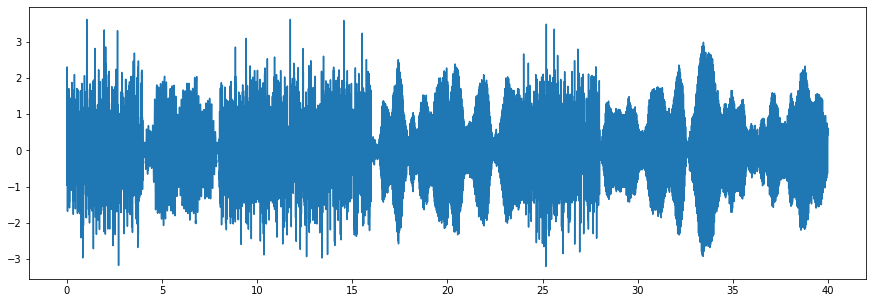

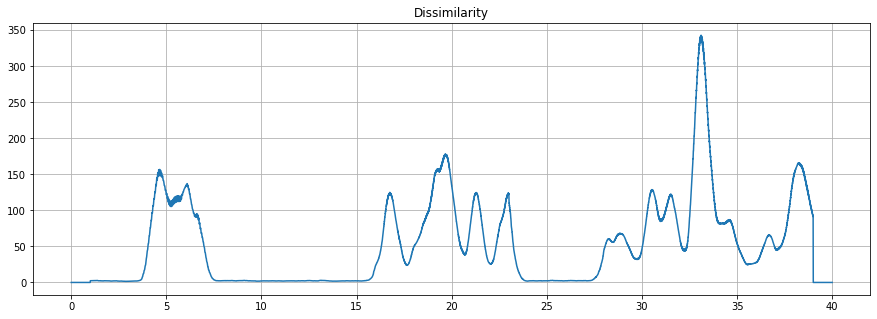

In [12]:
dissimilarity_vec = dissimilarity(eeg_signal,fs)
time_vec = np.arange(0,N/fs,1/fs)

plt.figure(figsize=(15,5))
plt.plot(time_vec,eeg_signal)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(time_vec,dissimilarity_vec)
plt.title("Dissimilarity")
plt.grid()
plt.show()

In [13]:
def segmentation(signal,dissimilarity_vec,threshold):
  segments=[[]]
  k = 0 
  i = fs
  i_previous = 0
# reference window makes zeros in dissimilarity, we analize starting from fs 
  while i < (N-fs-1):
    # if there is a change either up or down the threshold -> new segment
    if((dissimilarity_vec[i]<threshold) & (dissimilarity_vec[i+1]>=threshold)): 
      i = i+1
      segments[k].append(signal[i_previous:i])
      i_previous = i
      k = k+1
      segments.append([])
    if((dissimilarity_vec[i]>threshold) & (dissimilarity_vec[i+1]<=threshold)): 
      i = i+1
      segments[k].append(signal[i_previous:i])
      i_previous = i
      k = k+1
      segments.append([])
    i = i+1
  return segments

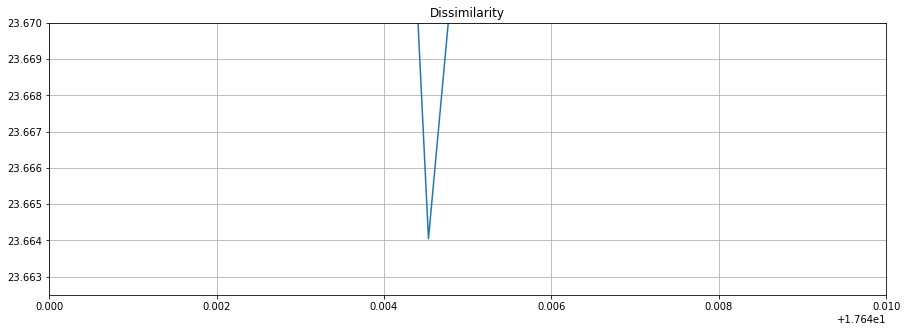

In [14]:
plt.figure(figsize=(15,5))
plt.plot(time_vec,dissimilarity_vec)
plt.xlim(17.64,17.65)
plt.ylim(23.6625,23.67)
plt.title("Dissimilarity")
plt.grid()
plt.show()


In [15]:
# def find_threshold(dissimilarity_vec):
#   maximum = 0
#   for i in range(0,len(dissimilarity_vec)):
#     while(dissimilarity_vec[i]>)
#   return maximum

In [16]:
# threshold = find_threshold(dissimilarity_vec)
# threshold

In [17]:
threshold = 23.664
EEG_segments = segmentation(eeg_signal,dissimilarity_vec,threshold)
len(EEG_segments)

6

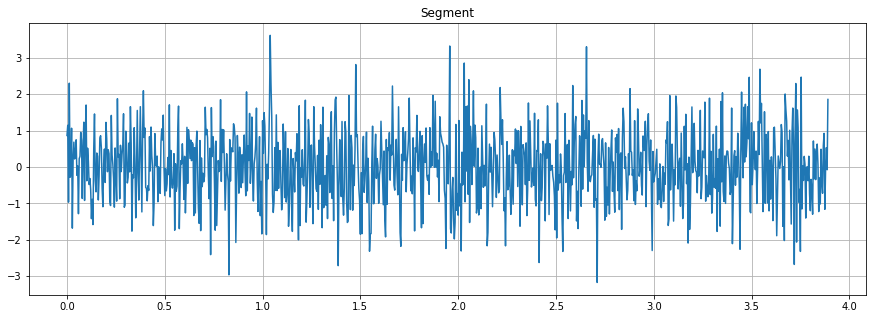

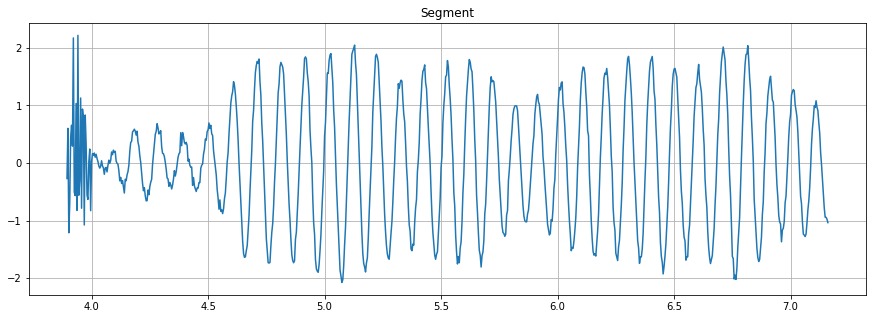

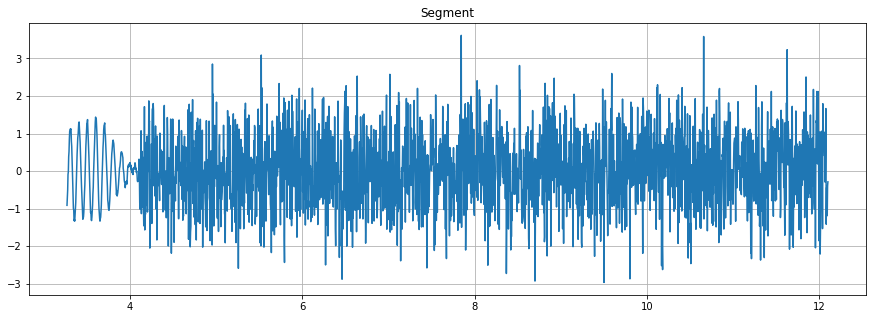

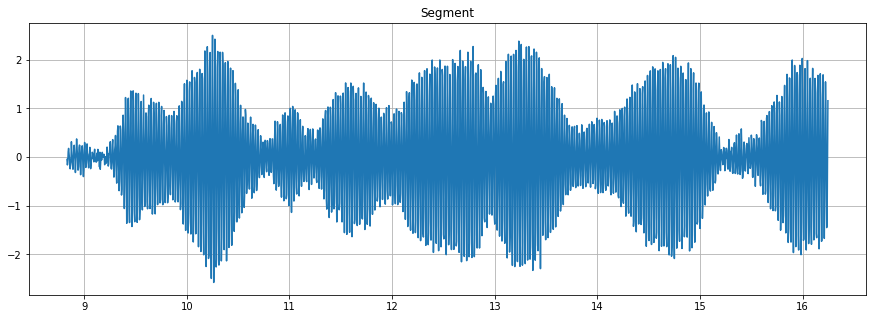

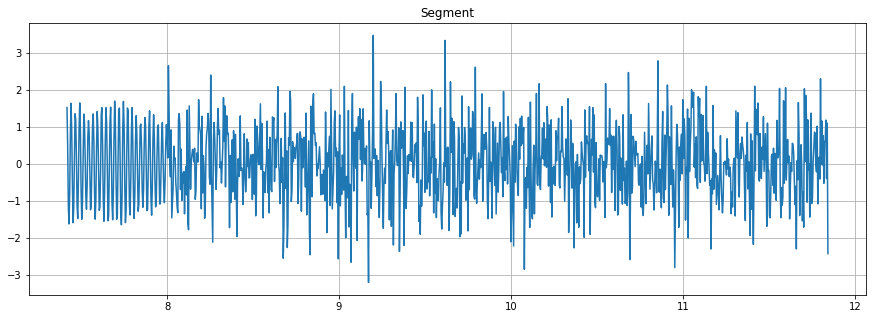

In [18]:
n_previous = 0
for i in range(0,len(EEG_segments)):
  for k in range(0, len(EEG_segments[i])):
    time_vec_segments= np.arange(n_previous/fs,(n_previous+len(EEG_segments[i][k]))/fs,1/fs)
    n_previous = len(EEG_segments[i][k])
    plt.figure(figsize=(15,5))
    plt.plot(time_vec_segments,EEG_segments[i][k][:])
    plt.title("Segment")
    plt.grid()
    plt.show()

Segmento la señal y obtengo los periodogramas de cada segmento para caracterizarlos

In [19]:
# # Hago periodograma de cada segmento
# FFT_EEG_seg = np.zeros()
# FFT_EEG_seg[0]= np.fft.fft(x_n)
# S_EEG_seg[0] = (np.abs(FFT_EEG_seg[0])**2)/fs
# for n in range(1,step_amount):
#   x_n = eeg_signal[n*fs:(n+1)*fs]
#   FFT_EEG_seg[n] = np.fft.fft(x_n)
#   S_EEG_seg[n] = (np.abs(FFT_EEG_seg[n])**2)/fs


# freq=np.linspace(0,2*np.pi,N)
# plt.plot(freq,S_EEG_seg)
# plt.xlim(0,np.pi)

In [20]:
# Segments periodogram
def periodogram_segments(segments):
  periodogram_seg = [[]]
  freq_seg = [[]]
  k = 0
  for i in range(0,len(segments)-1):
    periodogram_seg[k].append(periodogram(segments[i][0]))
    freq_seg[k].append(np.linspace(0,2*np.pi,len(segments[i][0])))
    k = k+1
    periodogram_seg.append([])
    freq_seg.append([])
  return freq_seg,periodogram_seg

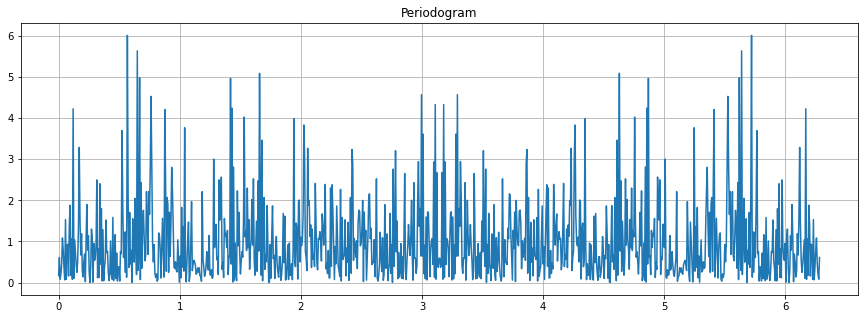

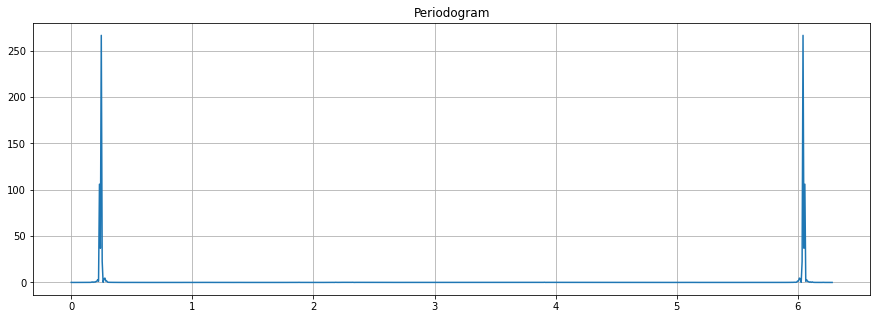

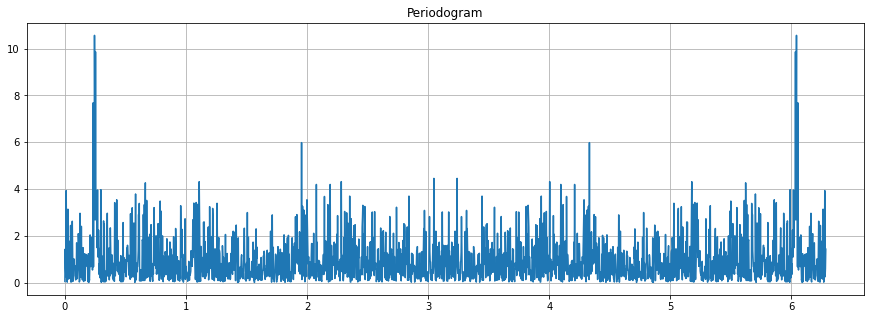

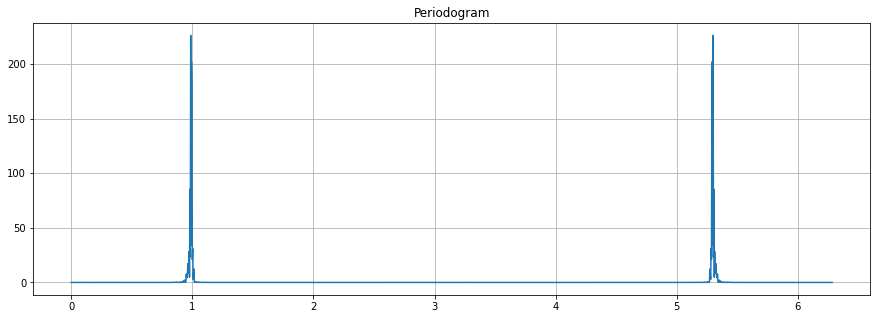

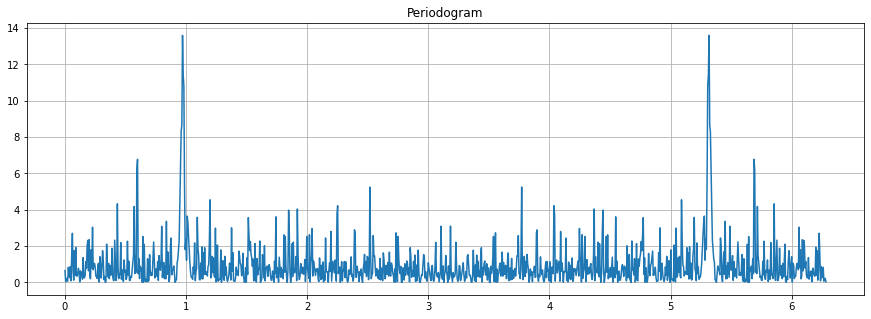

In [21]:
freq_seg,periodogram_seg = periodogram_segments(EEG_segments)
for i in range(0,len(EEG_segments)-1):
  plt.figure(figsize=(15,5))
  plt.plot(freq_seg[i][0],periodogram_seg[i][0])
  plt.title("Periodogram")
  plt.grid()
  plt.show()

## Consigna 2: Segmentación con ventana de referencia móvil.
 Relocalizamos la ventana de referencia en cada cambio de segmento

In [22]:
def dissimilarity_moving_ref(signal,fs,threshold):
  length = len(signal)
  step_amount = int((length-fs)/fs)
  dissimilarity_vec = np.zeros(length)
  
  # steady window of at least 1s to assure stacionarity
  x_0 = signal[0:fs]
  r_x_0 = np.correlate(x_0,x_0,"full")


  # for n in range(1,step_amount):
  #   x_n = eeg_signal[n*fs:(n+1)*fs]
  for n in np.arange(fs,N-fs):
    x_n = signal[n:(n+fs)]
    r_x_n = np.correlate(x_n,x_n,"full")
    # plt.plot(r_x_n)
    # plt.show()
    dissimilarity_vec[n] = np.sum((r_x_n-r_x_0)**2 ) / (r_x_n[fs-1]*r_x_0[fs-1])

    if (dissimilarity_vec[n] >= threshold):
      x_0 = x_n
      r_x_0 = np.correlate(x_0,x_0,'full')
    
  return dissimilarity_vec

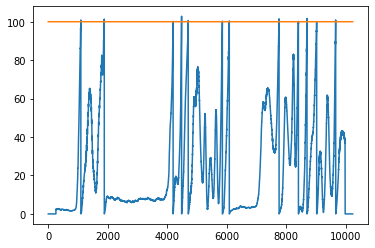

In [23]:
threshold2 = 100
dissimilarity_mov_ref = dissimilarity_moving_ref(eeg_signal,fs,threshold2)

plt.plot(dissimilarity_mov_ref)
plt.plot(np.ones(N)*100)

63.0442156454464


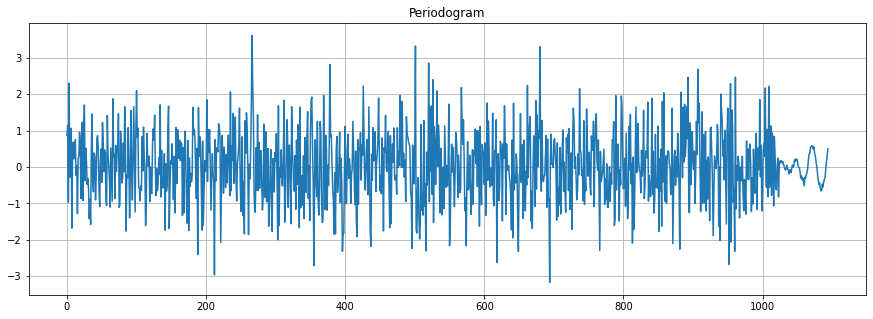

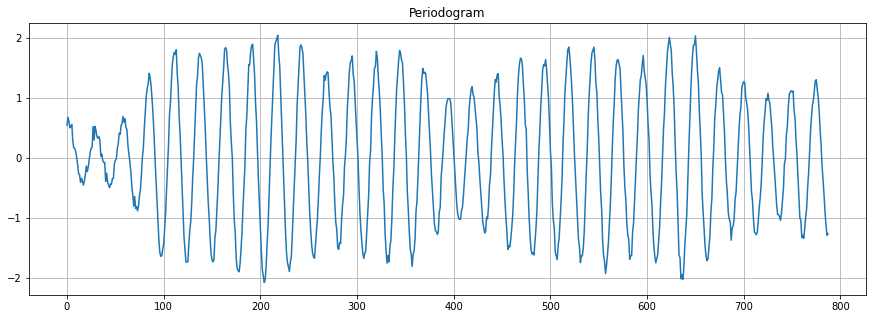

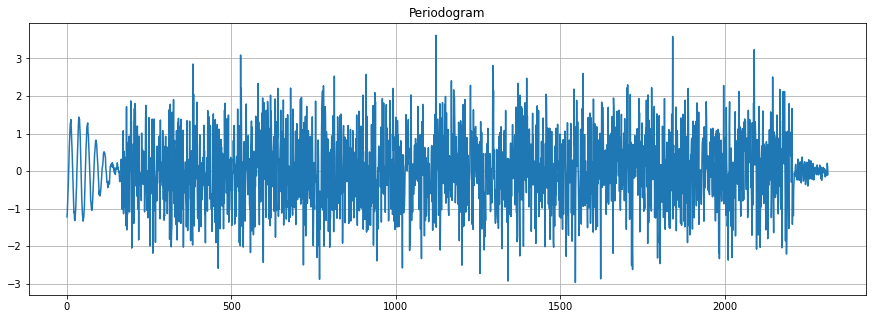

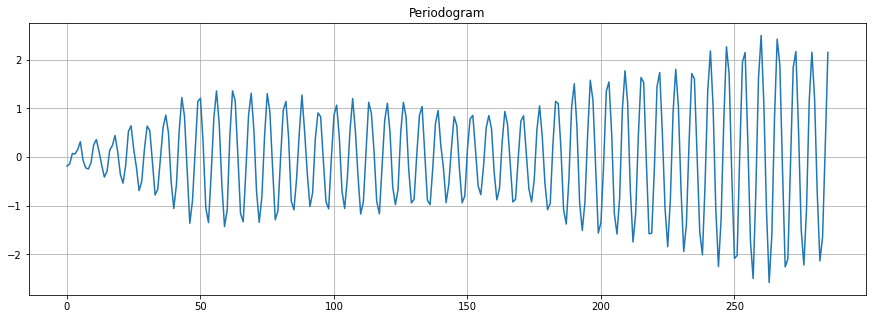

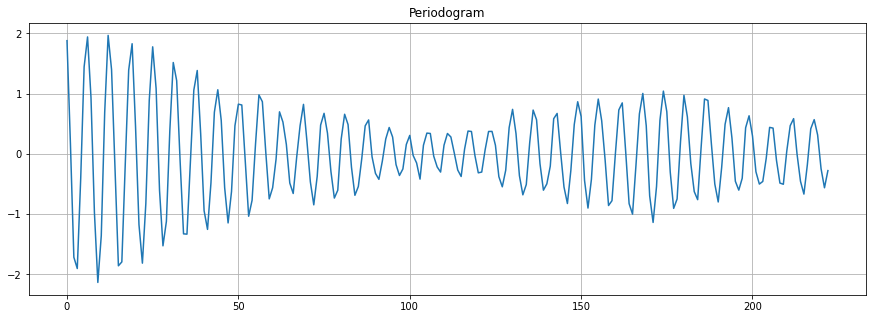

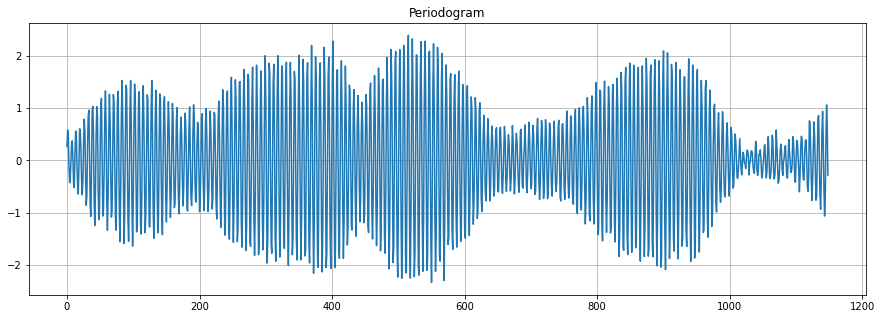

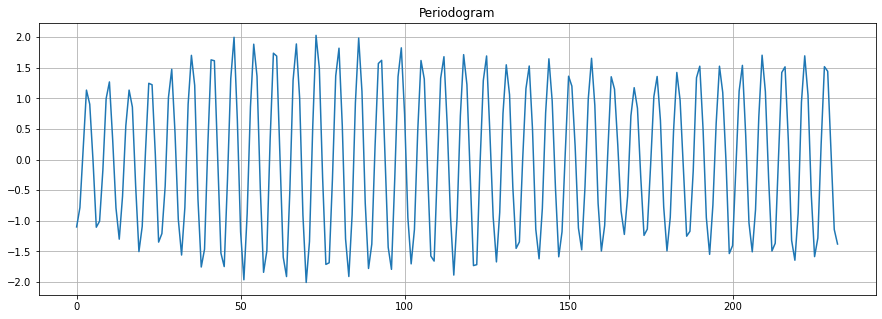

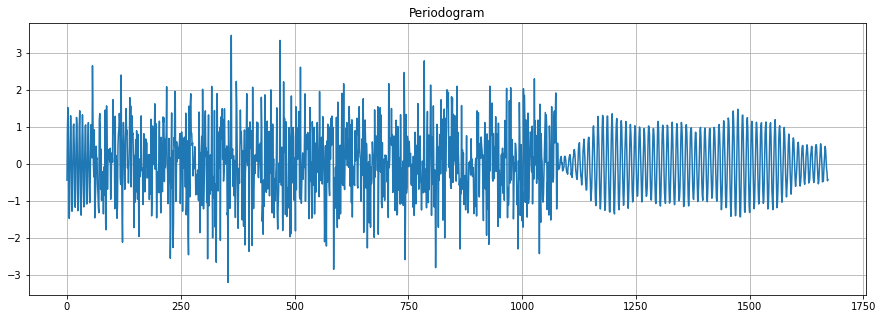

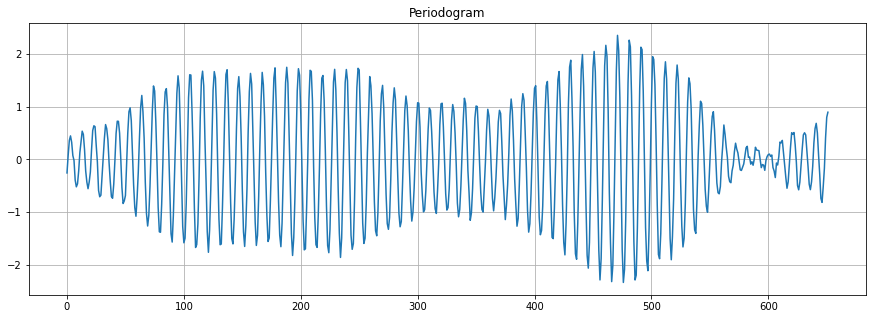

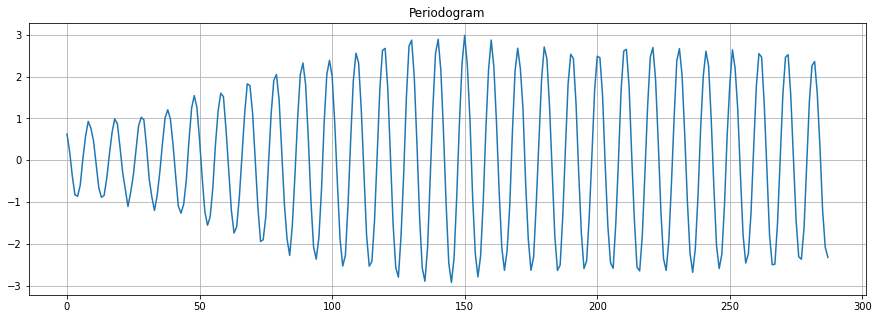

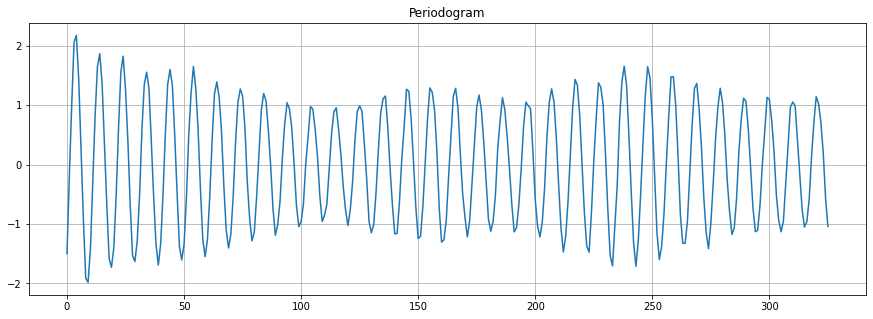

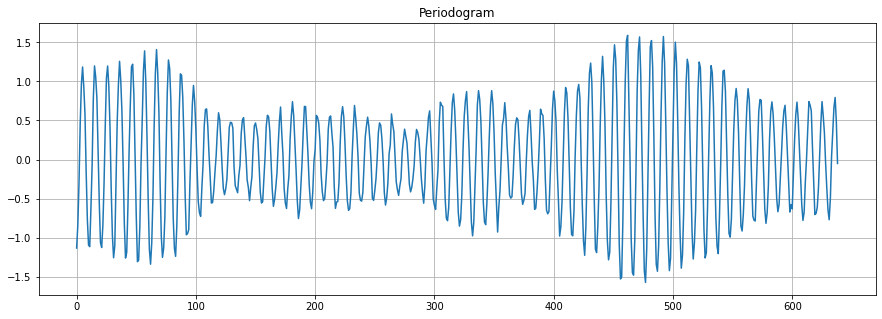

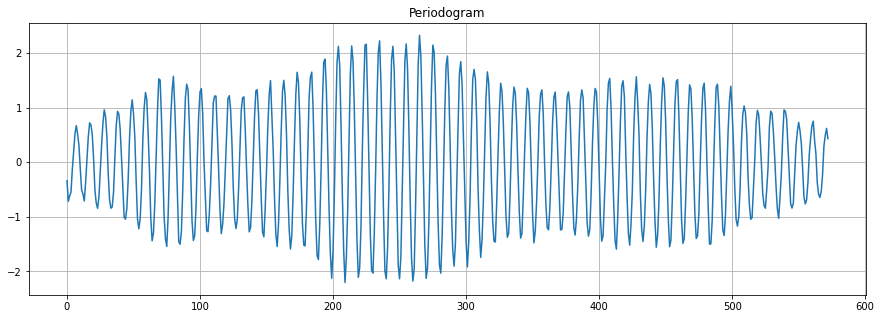

In [25]:
x_0 = eeg_signal[4*fs+100:5*fs+100]
r_x_0 = np.correlate(x_0,x_0,'full')

x_n = eeg_signal[5*fs+100:6*fs+100]
r_x_n = np.correlate(x_n,x_n,'full')

print( np.sum((r_x_n - r_x_0)**2)/(r_x_n[fs-1]*r_x_0[fs-1]))

EEG_segments2 = [[0,0]]
j = 0
for i in range(N):
  if dissimilarity_mov_ref[i]>=threshold2:
    EEG_segments2[j][1] = i
    EEG_segments2.append([i,0])
    j=j+1
EEG_segments2[j][1] = N

for i in np.arange(len(EEG_segments2)):
  plt.figure(figsize=(15,5))
  plt.plot(eeg_signal[EEG_segments2[i][0]:EEG_segments2[i][1]])
  plt.title("Periodogram")
  plt.grid()
  plt.show()


## Consigna 3: Segmentación paramétrica sobre la misma señal. 
Calculamos el modelo AR que ajusta a la señal de la ventana de referencia y luego medimos la salida de ese modelo para las señales de testeo. Si la salida se acerca a ruido blanco, luego las señales de testeo son similares a la de referencia. 

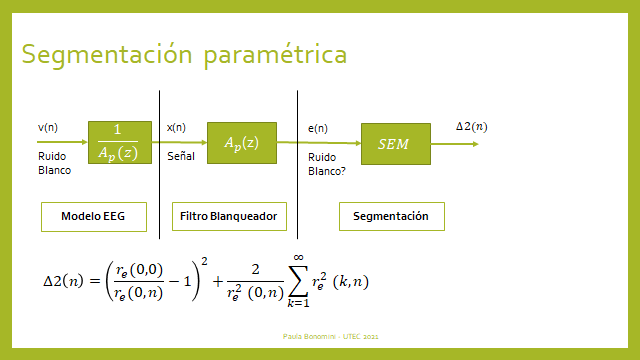